In [ ]:
# https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Parameters

In [37]:
train_size, val_size = 0.5, 0.2

### Data description

We use a real-world traffic speed dataset named `PeMSD7`. We use the version
collected and prepared by [Yu et al., 2018](https://arxiv.org/abs/1709.04875)
and available
[here](https://github.com/VeritasYin/STGCN_IJCAI-18/tree/master/data_loader).

The data consists of two files:

- `W_228.csv` contains the distances between 228
stations across the District 7 of California.
- `V_228.csv` contains traffic
speed collected for those stations in the weekdays of May and June of 2012.

The full description of the dataset can be found in
[Yu et al., 2018](https://arxiv.org/abs/1709.04875).

In [2]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/data_loader/PeMS-M.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip(".zip")

route_distances = pd.read_csv(
    os.path.join(data_dir, "W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(os.path.join(data_dir, "V_228.csv"), header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

6129354/6129354 [==============================] - 2s 0us/step
route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [7]:
speeds_array

array([[71.1, 66. , 64.6, ..., 69.3, 67.7, 68.9],
       [68.1, 66.8, 61.7, ..., 67.7, 68.8, 68.8],
       [68. , 64.3, 66.6, ..., 70.2, 69.1, 68.7],
       ...,
       [68.9, 37.9, 68.8, ..., 68.7, 67.5, 19.7],
       [69.2, 37.8, 68.7, ..., 67.7, 67.4, 19.5],
       [68.6, 52.9, 68.6, ..., 68.1, 68.5, 19.1]])

In [5]:
speeds_array

(12672, 228)

### sub-sampling roads

To reduce the problem size and make the training faster, we will only
work with a sample of 26 roads out of the 228 roads in the dataset.
We have chosen the roads by starting from road 0, choosing the 5 closest
roads to it, and continuing this process until we get 25 roads. You can choose
any other subset of the roads. We chose the roads in this way to increase the likelihood
of having roads with correlated speed timeseries.
`sample_routes` contains the IDs of the selected roads.

In [13]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


### Data visualization

Here are the timeseries of the traffic speed for two of the routes:

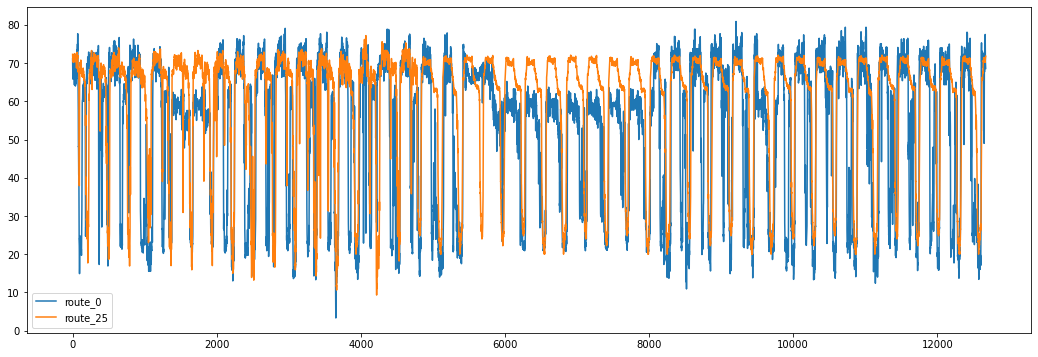

In [14]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

We can also visualize the correlation between the timeseries in different routes.

Text(0, 0.5, 'road number')

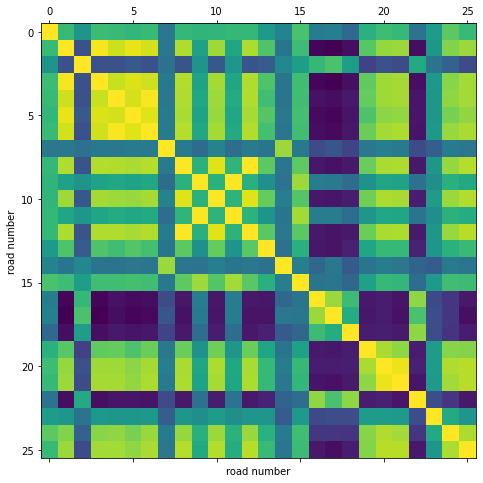

In [32]:
data = np.corrcoef(speeds_array.T)
plt.figure(figsize=(8, 8))
plt.matshow(data, 0)
plt.xlabel("road number")
plt.ylabel("road number")

/tmp/ipykernel_640/4157620760.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+alphabets)
/tmp/ipykernel_640/4157620760.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+alphabets)


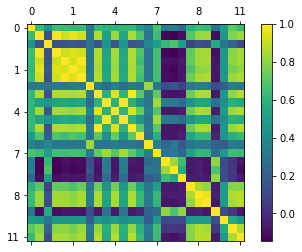

In [36]:
import numpy as np
import matplotlib.pyplot as plt
 
alphabets = [str(i) for i in sample_routes]

# randomly generated array
random_array = data
 
figure = plt.figure()
axes = figure.add_subplot(111)
 
# using the matshow() function
caxes = axes.matshow(random_array, interpolation ='nearest')
figure.colorbar(caxes)
 
axes.set_xticklabels(['']+alphabets)
axes.set_yticklabels(['']+alphabets)
 
plt.show()

In [38]:
def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


### Creating TensorFlow Datasets

Next, we create the datasets for our forecasting problem. The forecasting problem
can be stated as follows: given a sequence of the
road speed values at times `t+1, t+2, ..., t+T`, we want to predict the future values of
the roads speed for times `t+T+1, ..., t+T+h`. So for each time `t` the inputs to our
model are `T` vectors each of size `N` and the targets are `h` vectors each of size `N`,
where `N` is the number of roads.

We use the Keras built-in function
[`timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).
The function `create_tf_dataset()` below takes as input a `numpy.ndarray` and returns a
`tf.data.Dataset`. In this function `input_sequence_length=T` and `forecast_horizon=h`.

The argument `multi_horizon` needs more explanation. Assume `forecast_horizon=3`.
If `multi_horizon=True` then the model will make a forecast for time steps
`t+T+1, t+T+2, t+T+3`. So the target will have shape `(T,3)`. But if
`multi_horizon=False`, the model will make a forecast only for time step `t+T+3` and
so the target will have shape `(T, 1)`.

You may notice that the input tensor in each batch has shape
`(batch_size, input_sequence_length, num_routes, 1)`. The last dimension is added to
make the model more general: at each time step, the input features for each raod may
contain multiple timeseries. For instance, one might want to use temperature timeseries
in addition to historical values of the speed as input features. In this example,
however, the last dimension of the input is always 1.

We use the last 12 values of the speed in each road to forecast the speed for 3 time
steps ahead:

In [74]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()




In [57]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

In [80]:
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [110]:
print("number of timeseries points in training data ", len(train_array))

number of timeseries points in training data  6336


In [124]:
print(""" Shape form for Tensorflow data set, 
    Tensor Input:
    (batch_size, input_sequence_length, 
    number_of_routes, number_of_features) 
    \n input: """ 
      , t[0].shape, 
    "\n\n(batch_size, forecast_horizon, number_of_routes)",
    "\n test: ", t[1].shape)

 Shape form for Tensorflow data set, 
    Tensor Input:
    (batch_size, input_sequence_length, 
    number_of_routes, number_of_features) 
    
 input:  (64, 12, 26, 1) 

(batch_size, forecast_horizon, number_of_routes) 
 test:  (64, 3, 26)


In [118]:
print("Total number of batches in training: ", len(train_dataset))
print("""Total number of batches number of timeseries 
      points in training data set divided by batch_size""", 
     len(train_array) / batch_size)

Total number of batches in training:  99
Total number of batches number of timeseries 
      points in training data set divided by batch_size 99.0


### Roads Graph

As mentioned before, we assume that the road segments form a graph.
The `PeMSD7` dataset has the road segments distance. The next step
is to create the graph adjacency matrix from these distances. Following
[Yu et al., 2018](https://arxiv.org/abs/1709.04875) (equation 10) we assume there
is an edge between two nodes in the graph if the distance between the corresponding roads
is less than a threshold.

In [127]:

def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask


The function `compute_adjacency_matrix()` returns a boolean adjacency matrix
where 1 means there is an edge between two nodes. We use the following class
to store the information about the graph.

In [128]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 150


## Network architecture

Our model for forecasting over the graph consists of a graph convolution
layer and a LSTM layer.

### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation
in [this Keras example](https://keras.io/examples/graph/gnn_citations/). Note that
in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape
`(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer
performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages

In [134]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


### LSTM plus graph convolution

By applying the graph convolution layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `LSTMGC` layer below, first applies
a graph convolution layer to the inputs and then passes the results through a
`LSTM` layer.

In [136]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## Model training

In [137]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
99/99 [==============================] - 10s 76ms/step - loss: 0.6274 - val_loss: 0.3362
Epoch 2/20
99/99 [==============================] - 7s 71ms/step - loss: 0.2348 - val_loss: 0.1681
Epoch 3/20
99/99 [==============================] - 7s 71ms/step - loss: 0.1554 - val_loss: 0.1237
Epoch 4/20
99/99 [==============================] - 7s 72ms/step - loss: 0.1216 - val_loss: 0.0992
Epoch 5/20
99/99 [==============================] - 7s 71ms/step - loss: 0.0997 - val_loss: 0.0855
Epoch 6/20
99/99 [==============================] - 7s 70ms/step - loss: 0.0919 - val_loss: 0.0807
Epoch 7/20
99/99 [==============================] - 7s 71ms/step - loss: 0.0884 - val_loss: 0.0781
Epoch 8/20
99/99 [==============================] - 7s 68ms/step - loss: 0.0863 - val_loss: 0.0765
Epoch 9/20
99/99 [==============================] - 7s 68ms/step - loss: 0.0847 - val_loss: 0.0754
Epoch 10/20
99/99 [==============================] - 7s 68ms/step - loss: 0.0834 - val_loss: 0.0746
Epoch 11

## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. Below, we
compute the MAE of the model and compare it to the MAE of naive forecasts.
The naive forecasts are the last value of the speed for each node.

119/119 [==============================] - 2s 15ms/step
naive MAE: 0.13472308593195767, model MAE: 0.12750695534753664


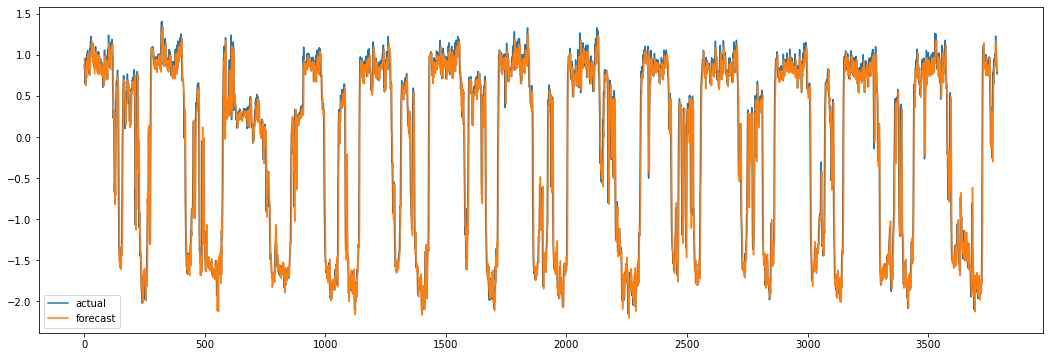

In [139]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

Of course, the goal here is to demonstrate the method,
not to achieve the best performance. To improve the
model's accuracy, all model hyperparameters should be tuned carefully. In addition,
several of the `LSTMGC` blocks can be stacked to increase the representation power
of the model.